In [171]:
using 
    Plots,
    StatPlots,
    RecipesBase,
    Colors, 
    Images,
    DataFrames,
    DataFramesMeta,
    Underscore,
    ConjugatePriors,
    Particles,
    Distances

flip(x::AbstractVector) = reshape(x, (1,:))

const It = Base.Iterators

using Revise
Revise.track("modeling.jl")
using DotLearning
include("experiments.jl")
include("plots.jl")

using JLD2
@load "data/dots2014.jld2"
@load "prior_empirical.jld2"
@load "results/run3-2018-07-18T12:40:07.059.jld2" results expts

2-element Array{Symbol,1}:
 :results
 :expts  

# Judgements are made in context

# Spatial memory task

* View location, then mask, then immediate recall.
* Dots occur in clusters of 3, 6, 9, or 12.

In [ ]:
recall1 = @where(recall, :subjid1 .== first(:subjid1))

In [85]:
@userplot Arena
@recipe function f(p::Arena)

    seriestype --> :scatter
    aspect_ratio --> :equal
    axis --> false
    grid --> false
    legend --> false
    
    x, y = length(p.args)==2 ? p.args : ([], [])
    @series begin
        seriestype --> :scatter
        x,y
    end

    @series begin
        group := nothing
        color := Gray(0.2)
        seriestype := :path
        cos.(linspace(0,2π,200)), sin.(linspace(0,2π,200))
    end
    
end

Plots.group_as_matrix(::Arena) = true

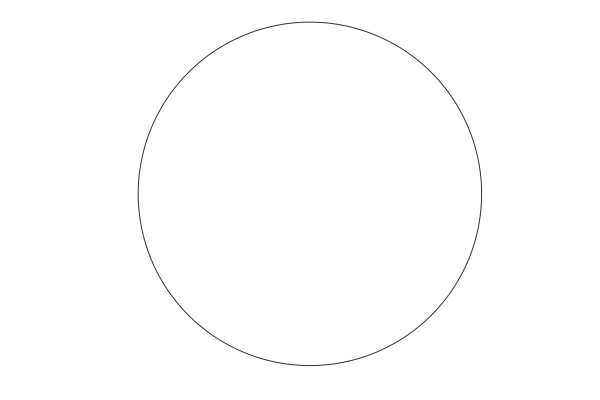

In [77]:
arena()
#plot!(cos.(linspace(0,2π)), sin.(linspace(0,2π)), color=Gray(0.2), seriestype=:path)

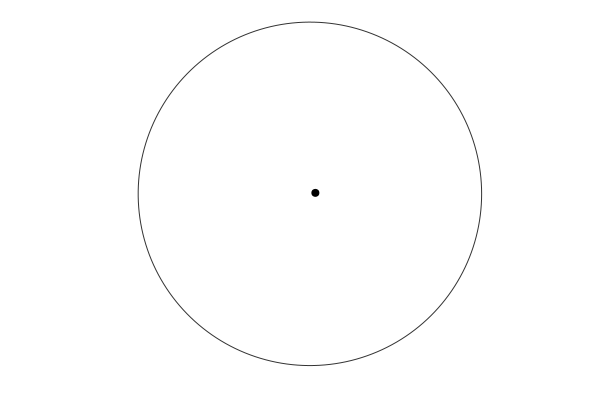

In [78]:
@df recall1 arena(:x[1:1], :y[1:1], color="black")

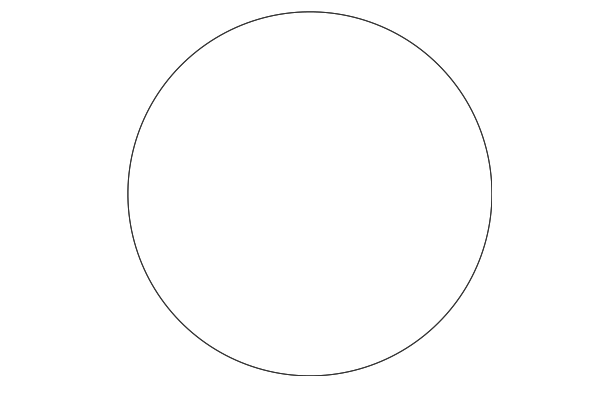

In [80]:
# p = plot([], [], xlim=(-1,1), ylim=(-1,1), seriestype=:scatter, legend=false, 
#          color="black", markersize=3,
#          markeralpha=0.2)
p = arena!()


In [81]:
anim = @animate for (x,y) in @_ zip(recall1[:x], recall1[:y]) |> It.drop(_, 20) |> It.take(_, 20)
    push!(p, x,y)
end

gif(anim, "figures/task.gif", fps=10)

INFO: Saved animation to /home/dave/work/dots-location-memory-pernille/figures/task.gif


Plots.AnimatedGif("/home/dave/work/dots-location-memory-pernille/figures/task.gif")

# Recall is biased

* negative relationship between study and recall radius: more likely to under estimate a large radius
* "shrinkage"

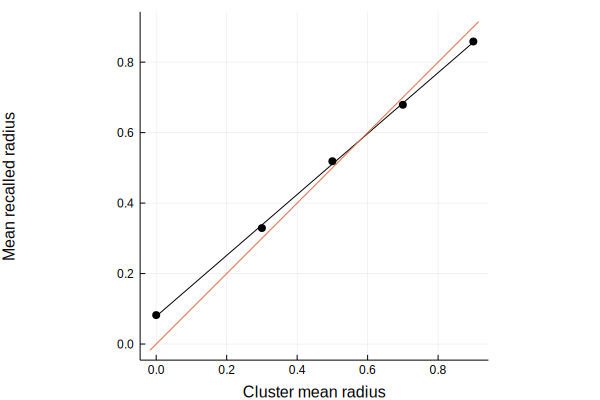

In [19]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_resp, color=:black, smooth=true, aspect_ratio=:equal, legend=false,
                   xlabel="Cluster mean radius", ylabel="Mean recalled radius"))

plot!(x->x, label="")

* Can see this more clearly plotting as the _bias_:
* negative slope means _shrinkage_

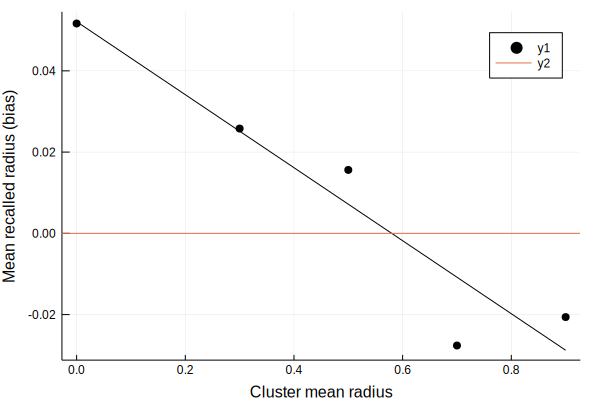

In [20]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_bias, color=:black, smooth=true, xlabel="Cluster mean radius", ylabel="Mean recalled radius (bias)"))
plot!(0,0, seriestype=:hline)
hline!([0])

* how do we know that people are picking up on the clusters?
* That bias is stronger early in a cluster, suggesting people fall back on a global estimate in the absence of information about the specific cluster:

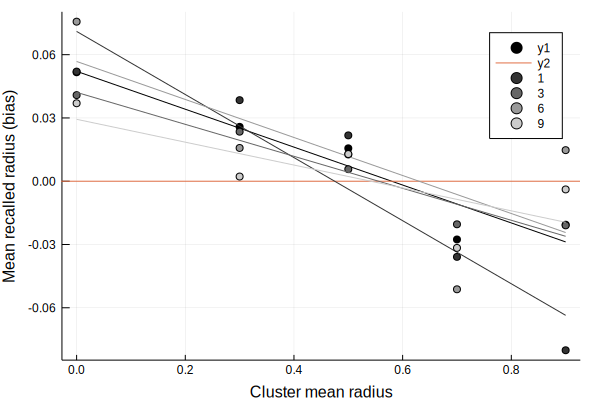

In [21]:
@_ recall |>
    @where(_, :block .> 1, [r ∈ [1,3,6,9] for r in :rep]) |>
    @by(_, [:rad, :rep], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter!(:rad, :rho_bias, group=:rep, color=Gray.([.2 .4 .6 .8]), smooth=true, markeralpha=1))

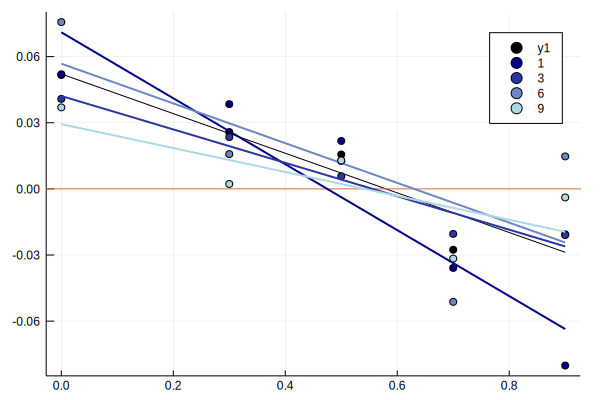

In [22]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_bias, color=:black, smooth=true))
plot!(0,0, seriestype=:hline)
hline!([0], label="")

@_ recall |>
    @where(_, :block .> 1, [r ∈ [1,3,6,9] for r in :rep]) |>
    @by(_, [:rad, :rep], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter!(:rad, :rho_bias, group=:rep, markerz=.-:rep, line=2, linez=.-:rep, color=:blues, smooth=true, markeralpha=1, colorbar=false))

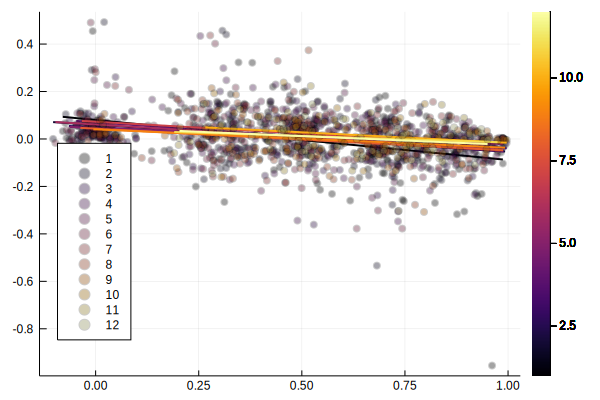

In [23]:
@_ recall |>
    @where(_, :block .> 1) |>
    @df(_, scatter(:rho ./ 2π, (abs.(:rho_resp).-abs.(:rho)) ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:bottomleft))

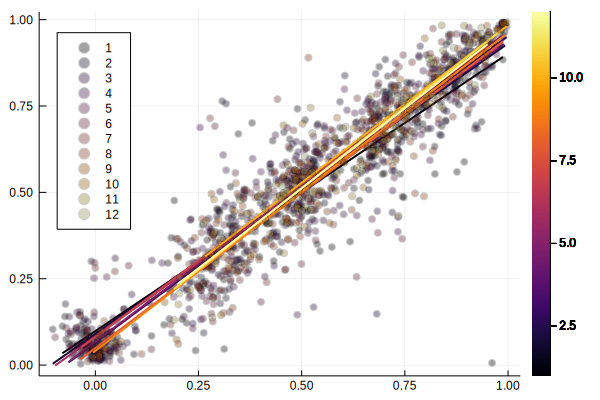

In [24]:
@_ recall |>
    @where(_, :block .> 1) |>
    @df(_, scatter(:rho ./ 2π, :rho_resp ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:topleft))

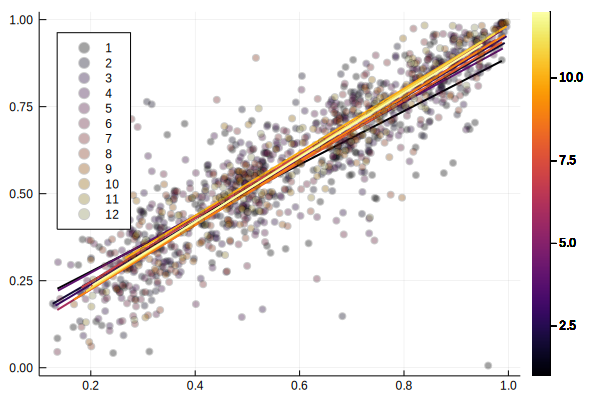

In [25]:
@_ recall |>
    @where(_, :block .> 1, :rad .> 0) |>
    @df(_, scatter(:rho ./ 2π, :rho_resp ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:topleft))

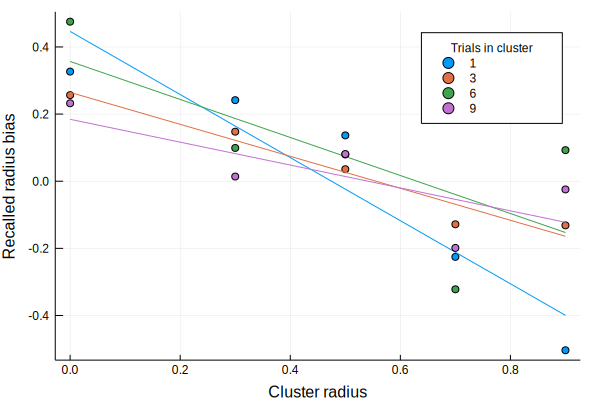

In [26]:
@_ recall |>
    @where(_, :block .> 1, [r ∈ [1, 3, 6, 9] for r in :rep]) |>
    @by(_, [:rep, :rad], rho_bias = mean(:new_rho_bias)) |>
    @df(_, scatter(:rad, :rho_bias, group=:rep, smooth=true, colorbar=false,
        legend_title="Trials in cluster",
                   xlabel="Cluster radius", ylabel="Recalled radius bias"))

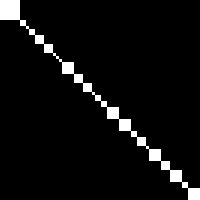

In [27]:
true_assignsim = Gray.(@with(recall1, :block .== :block'))

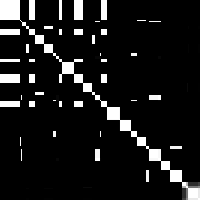

In [28]:
ps = ChenLiuParticles(1000, prior_optimized, StickyCRP(1.0, 0.9))
filter!(ps, extract_data(recall1, ps), false)
stickycrp = show_assignment_similarity(ps)

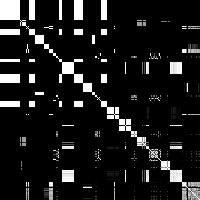

In [90]:
ps_crp = @_ ChineseRestaurantProcess(1.0) |>
    ChenLiuParticles(100, prior_optimized, _) |>
    filter!(_, extract_data(recall1, _), false)
crp = ps_crp |> show_assignment_similarity

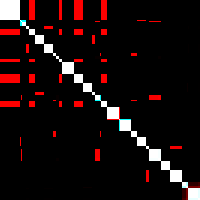

In [30]:
colorview(RGB, stickycrp, true_assignsim, true_assignsim)

In [43]:
assignments(ps)
sort!(ps.particles, by=weight, rev=true)
weight.(ps.particles)

1000-element Array{Float64,1}:
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 0.00160374
 ⋮         
 6.83833e-5
 2.26408e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 2.21816e-5
 1.0978e-5 
 1.0978e-5 

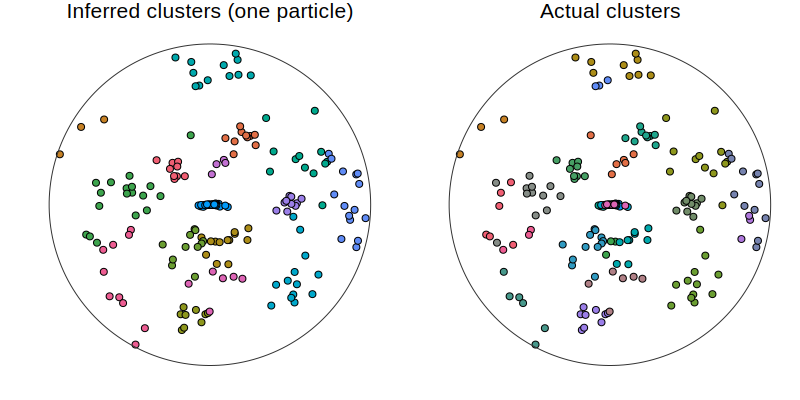

In [126]:
p1 = @df recall1 arena(:x, :y, group = assignments(first(ps.particles)), 
                     title = "Inferred clusters (one particle)")

p2 = @df recall1 arena(:x, :y, group = :block, title="Actual clusters")

plot(p1, p2, size=(800, 400))

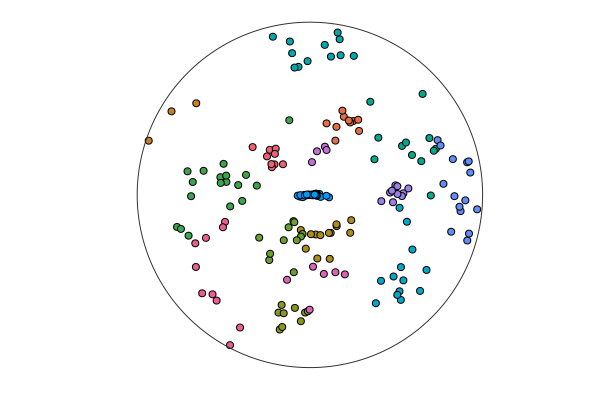

In [127]:
@df recall1 arena(:x, :y, group=assignments(first(ps.particles)))

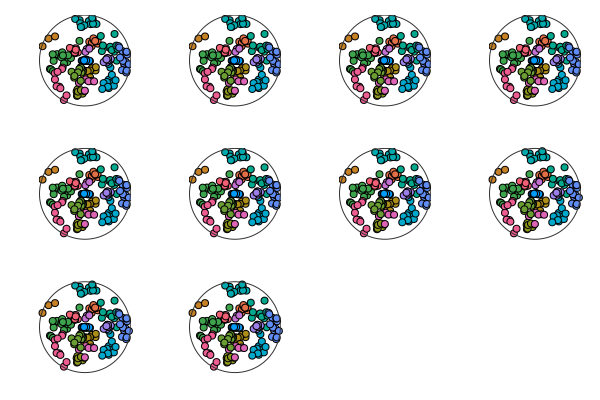

In [129]:
parts100 = map(ps.particles[1:10]) do particle
    @df recall1 arena(:x, :y, group = assignments(particle), lims=(-1,1))
end;

plot(parts100...)

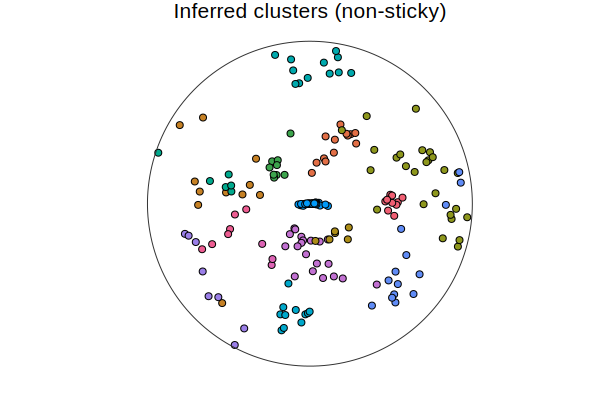

In [131]:
sort!(ps_crp.particles, by=weight, rev=true)
@df recall1 arena(:x, :y, group = assignments(first(ps_crp.particles)), 
                  title = "Inferred clusters (non-sticky)")

* for the most part, can separate clusters based on _sequence_, where the non-sticky often over- or under-clusters

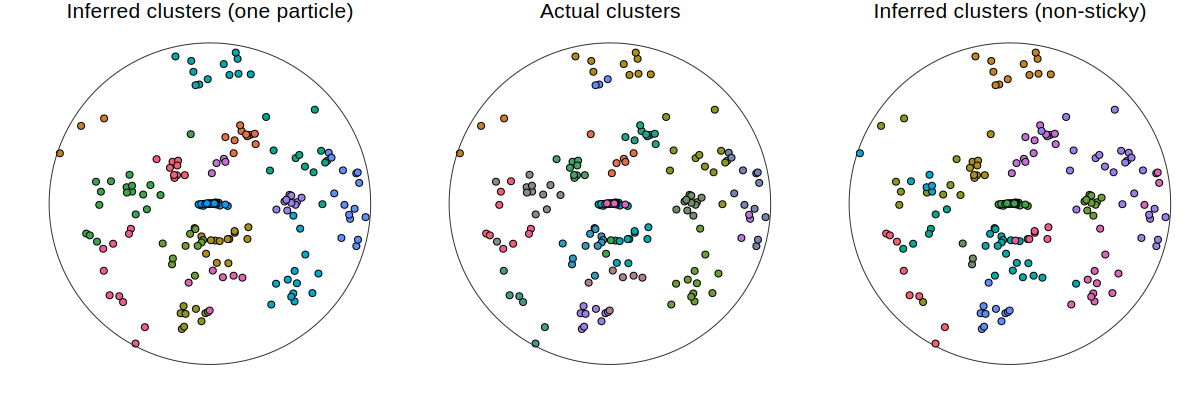

In [132]:
plot(p1, p2, p3, layout=(1,3), size=(1200,400))

# Modeling behavior

* Recall: modeled as Bayesian cue combination (after Huttenlocher)
* two cues: thing you saw, and inferred context
* weighted average (by inverse-variance)

In [215]:
# result:
#   .experiment:
#     .data:
#     - (recall1, recall2, ...)
#     - (pred1, pred2, ...)
#   .result
#   - (recalled1, predicted1)
#   - (recalled2, predicted2)
#   - ...

function add_params!(df::AbstractDataFrame, params)
    for (k,v) in params
        df[k] = v
    end
    df
end

# extract input data (which is by subject) and predictions
recalled(r) =
    add_params!(hcat(vcat(r.experiment.data[1]...),
                     vcat(first.(r.result)...)),
                r.experiment.params)

predicted(r) =
    add_params!(hcat(vcat(r.experiment.data[2]...),
                     vcat(last.(r.result)...)[[:xys_mod]]),
                r.experiment.params)

predicted (generic function with 2 methods)

In [220]:
recalled_all = mapreduce(recalled, vcat, results)

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod,α,ρ,Sσ,batch,n,iter,prior
1,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.0318544,0.00563721,0.0323494,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
2,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0279637,0.000499986,0.0279681,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
3,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,-0.0144499,-0.00039846,0.0144554,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
4,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.048923,-0.00365995,0.0490597,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
5,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,-0.0288976,-0.000884699,0.0289112,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
6,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.00872238,-0.000389493,0.00873107,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
7,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0301588,0.00263369,0.0302736,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
8,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0341805,0.00374106,0.0343846,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
9,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,-0.0055706,0.00140054,0.00574396,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( di

In [226]:
cosinesim(d) = cosinesim(d,d)
mse(d) = mse(d,d)

recalled_summaries = by(recalled_all, [:α, :ρ, :Sσ], d -> DataFrame(cos=cosinesim(d), mse=mse(d)))

sort!(recalled_summaries, :cos, rev=true)

,α,ρ,Sσ,cos,mse
1,0.01,0.9,0.0001,0.111026,0.118928
2,0.01,0.9,0.01,0.11091,0.123901
3,0.01,0.9,1.0,0.108999,0.191337
4,0.01,0.5,0.01,0.108211,0.124358
5,0.01,0.5,1.0,0.107472,0.185677
6,0.1,0.9,0.01,0.106895,0.123387
7,0.1,0.9,0.0001,0.103473,0.118935
8,1.0,0.9,0.01,0.103041,0.122893
9,0.1,0.9,1.0,0.102065,0.161558
10,0.01,0.5,0.0001,0.100513,0.11894


In [216]:
predicted(first(results))

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,xys_mod,α,ρ,Sσ,batch,n,iter,prior
1,1.0,1.0,20.0,20,1.0,0.0,0.0,10,0.0,2.0,2.95271,0.0,0.0,1.3258,0.0,0.0301,20.0,1.3258,1.3258,[0.00656041 0.0110506; -0.0871856 0.0503349; 0.0123476 -0.0270813; 0.00508156 0.0298128; 0.0255449 -0.0197432; 0.00627091 0.0154756; 0.0261185 -0.0454086; 0.0126118 -0.000851125; 0.118573 0.0085811; 0.016521 -0.0107948; -0.0580539 0.0027037; -0.0175737 0.00702507; 0.026654 -0.00414482; 0.0656255 -0.0107643; 0.0402699 -0.0175532; -0.00437191 -0.018168; 0.0414141 -0.0120271; 0.107243 0.0272456; 0.0669619 -0.00903856; -0.0793927 0.0151557; 0.0662224 -0.0140513; -0.0456345 -0.0385879; 0.00860959 -0.00511373; 0.0475725 0.0155221; -0.0514368 0.0210429; 0.0769447 -0.0138427; 0.060441 0.00500692; 0.018261 -0.00345898; 0.0281351 -0.02074; 0.0453223 0.0193783; 0.0260341 -0.034116; 0.0664945 0.00896816; 0.00952442 -0.0345054; 0.0377564 0.0110185; 0.0137816 0.00784471; 0.0059652 0.0027785; 0.0481598 -0.017409; 0.0394005 0.0107286; 0.00677298 -0.00555937; 0.104165 0.00766955; 0.0570417 -0.0117268; 0.00291442 -0.00108859; -0.0362887 -0.0120577; 0.0333449 0.0078699; 0.0861002 0.0134857; 0.0687045 0.0189197; 0.00522687 0.0191799; -0.0108669 -0.0309603; 0.0089185 0.0328648; 0.0561415 -0.00736763; -0.0284357 0.00874072; 0.060244 -0.0138002; -0.0150374 -0.00017444; 0.0974517 -0.0171316; 0.00724031 -0.0156385; 0.0577686 0.0284968; 0.0319207 -0.00409092; -0.0247326 -0.0170444; 0.028922 0.0042582; 0.0406967 0.010858; -0.0160978 -0.023868; -0.0720464 0.0170485; 0.00306255 0.00530234; 0.0244079 0.00252352; 0.0145147 0.00666067; 0.049048 -0.0118342; 0.0495199 -0.00331367; 0.0423134 -0.00959509; 0.0296042 -0.024517; 0.0671381 0.00176981; 0.0566386 0.00595178; 0.0198014 0.018478; 0.028285 0.00820753; 0.0261669 0.023802; 0.0364269 -0.0172867; 0.0338691 0.0103621; -0.0411101 -0.0195546; -0.0218778 -0.00514898; -0.0152082 -0.00980069; 0.0323812 -0.00567103; 0.00620197 0.0255543; 0.0134216 0.00184416; -0.0351013 0.0132115; -0.0330885 0.0143315; -0.00249856 -0.0276292; 0.0506464 -0.00679099; 0.000684398 -0.00506428; 0.0572655 -0.00312959; 0.0118336 0.0165041; 0.0872013 0.0162686; -0.00411681 0.00508814; 0.0553348 0.010613; 0.0512654 0.00639806; 0.0400484 0.0109113; 0.0278866 -0.00329926; 0.0599719 -0.0271751; 0.00907423 0.00119093; 0.0764158 0.0218916; 0.0162326 0.0435661; -0.00539351 0.0308462],0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
2,1.0,2.0,3.0,23,6.0,0.3,0.0,1,0.0,2.0,6.90309,0.0,0.0,1.2224,0.0,1.6465,6.0,1.2224,1.2224,[0.0175744 -0.000527685; -0.0598973 0.329553; 0.00397613 0.0338036; -0.0342567 0.00795109; 0.014255 0.0183773; -0.00888826 0.00867068; -0.0819877 0.49397; 2.85391e-5 -0.0014042; 0.0275137 0.36858; -0.0073788 0.00559206; 0.0314818 0.00930977; -0.0236427 0.0290957; -0.0130229 0.005589; 0.0689223 0.030651; 0.0919473 0.0189797; 0.147653 0.197233; 0.37633 0.282013; -0.0918306 0.295625; 0.0120736 0.0107009; 0.0260421 -0.00223996; 0.00523922 -0.0149637; 0.0471196 0.0224523; 0.00518175 -0.00425521; -0.0584753 0.333545; 0.0238155 0.00807782; 0.0385722 -0.0162315; 0.0477791 0.0200467; -0.01871 0.000861518; 0.00577646 -0.00158842; 0.0557742 0.0138274; 0.0102646 0.0107694; -0.147911 0.0220644; -0.0213701 0.017288; 0.108789 0.301436; -0.000346221 -0.00270284; -0.00362517 0.0152782; -0.0398058 0.447229; -0.0249669 0.293712; 0.00245123 -0.000572484; 0.0103822 0.0170408; -0.10558 0.531654; -0.00560741 -0.011196; 0.00378117 -0.00965454; 0.0470247 0.00680853; 0.17821 0.207957; 0.0312213 0.000430824; 0.00693186 -0.00576941; 0.162951 0.289897; 0.0503732 0.0244234; 0.0459517 0.0012806; 0.165925 0.25875; -0.0509203 0.383013; 0.0345027 0.00207831; 0.0117976 -0.00322655;

In [145]:
rf = RecallFilter(ChenLiuParticles(100, prior_optimized, StickyCRP(1.0, 0.9)), Matrix(0.1I, 2,2))
filter!(rf, extract_data(recall1, rf))
recalled1 = hcat(recall1, DataFrame(rf))

Fitting particles...100%|███████████████████████████████| Time: 0:00:07


,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,block_trial,x_mod,y_mod,rho_mod
1,1,1,1,1,1,0.0,0.01,0,false,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,1,0.0321233,0.00598468,0.032676
2,1,1,2,2,1,0.0,0.01,0,false,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,2,0.0299824,0.00316172,0.0301487
3,1,1,3,3,1,0.0,0.01,0,false,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,3,0.0142455,0.00193639,0.0143765
4,1,1,4,4,1,0.0,0.01,0,false,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,4,0.0240963,0.000440975,0.0241004
5,1,1,5,5,1,0.0,0.01,0,false,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,5,0.0119703,0.000185746,0.0119717
6,1,1,6,6,1,0.0,0.01,0,false,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,6,0.011982,8.74661e-5,0.0119824
7,1,1,7,7,1,0.0,0.01,0,false,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,7,0.0149964,0.000513667,0.0150052
8,1,1,8,8,1,0.0,0.01,0,false,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,8,0.0175852,0.000974294,0.0176122
9,1,1,9,9,1,0.0,0.01,0,false,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,9,0.0143772,0.00101393,0.0144129
10,1,1,10,10,1,0.0,0.01,0,false,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,10,0.0174478,0.000638689,0.0174595


In [147]:
mse(recalled1, recalled1), cosinesim(recalled1, recalled1)

(0.12667335315000866, 0.17778489618584592)

In [161]:
@_ recalled1 |>
    @where(_, :rad .> 0) |>
    cosinesim(_,_)

0.2289668907990987

In [162]:
by(recalled1, :rad, d -> cosinesim(d,d))

,rad,x1
1,0.0,-0.00367854
2,0.3,-0.0228822
3,0.9,0.483879
4,0.5,0.106506
5,0.7,0.385


* Here's what the data for one subject looks like:

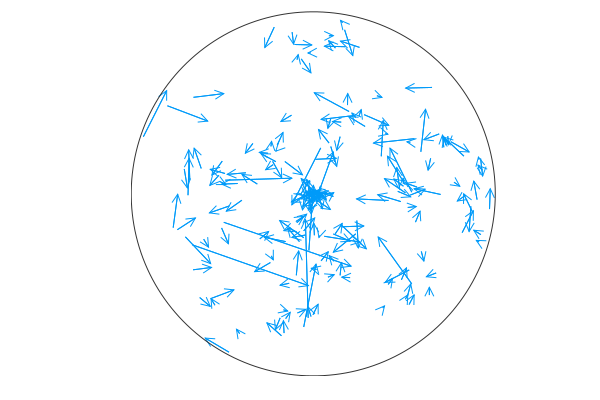

In [158]:
@df recall1 arena(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), seriestype=:quiver)

* And here's what the model predicts:

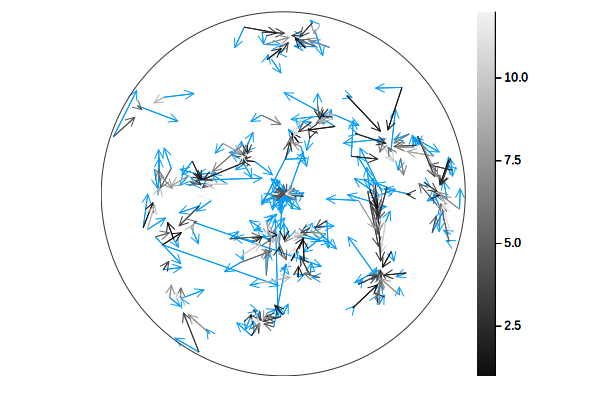

In [159]:
@_ recalled1 |>
    @where(_, :block .> 1) |>
    @df _ quiver!(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), linez=:rep, color=:grays, colorbar=true)

In [203]:
known_recalled = by(recall, :subjid1) do d
    @_ KnownFilter(prior_optimized) |>
    RecallFilter(_, Matrix(0.1I,2,2)) |>
    filter!(_, extract_data(d, _)) |>
    DataFrame |>
    hcat(d, _) |>
    delete!(_, :subjid1) |>
    @transform(_, cosinesim = 1.-Distances.colwise(CosineDist(), 
                                                   hcat(:x_mod.-:x, :y_mod.-:y)', 
                                                   hcat(:x_resp.-:x, :y_resp.-:y)'))
end

known_recalled1 = @where(known_recalled, :subjid1 .== 1)

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,block_trial,x_mod,y_mod,rho_mod,cosinesim
1,1,1,1,1,1,0.0,0.01,0,false,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,1,0.0321233,0.00598468,0.032676,-0.997584
2,1,1,2,2,1,0.0,0.01,0,false,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,2,0.0299824,0.00316172,0.0301487,-0.782162
3,1,1,3,3,1,0.0,0.01,0,false,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,3,0.0142455,0.00193639,0.0143765,-0.921388
4,1,1,4,4,1,0.0,0.01,0,false,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,4,0.0240963,0.000440975,0.0241004,-0.683219
5,1,1,5,5,1,0.0,0.01,0,false,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,5,0.0119703,0.000185746,0.0119717,0.812176
6,1,1,6,6,1,0.0,0.01,0,false,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,6,0.011982,8.74661e-5,0.0119824,-0.70504
7,1,1,7,7,1,0.0,0.01,0,false,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,7,0.0149964,0.000513667,0.0150052,-0.982486
8,1,1,8,8,1,0.0,0.01,0,false,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,8,0.0175852,0.000974294,0.0176122,0.694846
9,1,1,9,9,1,0.0,0.01,0,false,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,9,0.0143772,0.00101393,0.0144129,-0.723745
10,1,1,10,10,1,0.0,0.01,0,false,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,10,0.0174478,0.000638689,0.0174595,0.92735


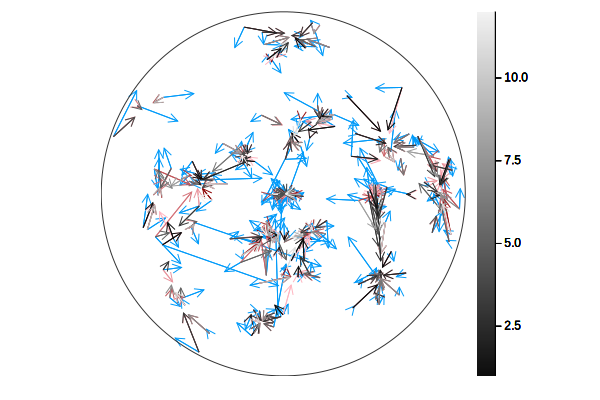

In [204]:
@df recall1 arena(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), seriestype=:quiver)

@_ known_recalled1 |>
    @where(_, :block .> 1) |>
    @df _ quiver!(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), linez=:rep, color=:reds, colorbar=true)



@_ recalled1 |>
    @where(_, :block .> 1) |>
    @df _ quiver!(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), linez=:rep, color=:grays, colorbar=true)

In [173]:

@transform(recalled1, cosinesim = 1.-Distances.colwise(CosineDist(), 
                                                       hcat(:x_mod.-:x, :y_mod.-:y)', 
                                                       hcat(:x_resp.-:x, :y_resp.-:y)'))

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,block_trial,x_mod,y_mod,rho_mod,cosinesim
1,1,1,1,1,1,0.0,0.01,0,false,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,1,0.0321233,0.00598468,0.032676,-0.997584
2,1,1,2,2,1,0.0,0.01,0,false,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,2,0.0299824,0.00316172,0.0301487,-0.782162
3,1,1,3,3,1,0.0,0.01,0,false,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,3,0.0142455,0.00193639,0.0143765,-0.921388
4,1,1,4,4,1,0.0,0.01,0,false,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,4,0.0240963,0.000440975,0.0241004,-0.683219
5,1,1,5,5,1,0.0,0.01,0,false,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,5,0.0119703,0.000185746,0.0119717,0.812176
6,1,1,6,6,1,0.0,0.01,0,false,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,6,0.011982,8.74661e-5,0.0119824,-0.70504
7,1,1,7,7,1,0.0,0.01,0,false,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,7,0.0149964,0.000513667,0.0150052,-0.982486
8,1,1,8,8,1,0.0,0.01,0,false,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,8,0.0175852,0.000974294,0.0176122,0.694846
9,1,1,9,9,1,0.0,0.01,0,false,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,9,0.0143772,0.00101393,0.0144129,-0.723745
10,1,1,10,10,1,0.0,0.01,0,false,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,10,0.0174478,0.000638689,0.0174595,0.92735


In [169]:
cosinesim(recalled1, recalled1), cosinesim(known_recalled1, known_recalled1)

(0.17778489618584592, 0.1708143106394221)

In [170]:
mse(recalled1, recalled1), mse(known_recalled1, known_recalled1)

(0.12667335315000866, 0.11623884140230455)

In [134]:
results[1].experiment.params

Dict{Symbol,Any} with 7 entries:
  :α     => 0.01
  :ρ     => 0.1
  :Sσ    => 0.0001
  :batch => :run2
  :n     => 100
  :iter  => 1
  :prior => ConjugatePriors.NormalInverseWishart{Float64}(…

In [199]:
pred1 = predicted(r1)

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,xys_mod
1,1.0,1.0,20.0,20,1.0,0.0,0.0,10,0.0,2.0,2.95271,0.0,0.0,1.3258,0.0,0.0301,20.0,1.3258,1.3258,[0.00656041 0.0110506; -0.0871856 0.0503349; 0.0123476 -0.0270813; 0.00508156 0.0298128; 0.0255449 -0.0197432; 0.00627091 0.0154756; 0.0261185 -0.0454086; 0.0126118 -0.000851125; 0.118573 0.0085811; 0.016521 -0.0107948; -0.0580539 0.0027037; -0.0175737 0.00702507; 0.026654 -0.00414482; 0.0656255 -0.0107643; 0.0402699 -0.0175532; -0.00437191 -0.018168; 0.0414141 -0.0120271; 0.107243 0.0272456; 0.0669619 -0.00903856; -0.0793927 0.0151557; 0.0662224 -0.0140513; -0.0456345 -0.0385879; 0.00860959 -0.00511373; 0.0475725 0.0155221; -0.0514368 0.0210429; 0.0769447 -0.0138427; 0.060441 0.00500692; 0.018261 -0.00345898; 0.0281351 -0.02074; 0.0453223 0.0193783; 0.0260341 -0.034116; 0.0664945 0.00896816; 0.00952442 -0.0345054; 0.0377564 0.0110185; 0.0137816 0.00784471; 0.0059652 0.0027785; 0.0481598 -0.017409; 0.0394005 0.0107286; 0.00677298 -0.00555937; 0.104165 0.00766955; 0.0570417 -0.0117268; 0.00291442 -0.00108859; -0.0362887 -0.0120577; 0.0333449 0.0078699; 0.0861002 0.0134857; 0.0687045 0.0189197; 0.00522687 0.0191799; -0.0108669 -0.0309603; 0.0089185 0.0328648; 0.0561415 -0.00736763; -0.0284357 0.00874072; 0.060244 -0.0138002; -0.0150374 -0.00017444; 0.0974517 -0.0171316; 0.00724031 -0.0156385; 0.0577686 0.0284968; 0.0319207 -0.00409092; -0.0247326 -0.0170444; 0.028922 0.0042582; 0.0406967 0.010858; -0.0160978 -0.023868; -0.0720464 0.0170485; 0.00306255 0.00530234; 0.0244079 0.00252352; 0.0145147 0.00666067; 0.049048 -0.0118342; 0.0495199 -0.00331367; 0.0423134 -0.00959509; 0.0296042 -0.024517; 0.0671381 0.00176981; 0.0566386 0.00595178; 0.0198014 0.018478; 0.028285 0.00820753; 0.0261669 0.023802; 0.0364269 -0.0172867; 0.0338691 0.0103621; -0.0411101 -0.0195546; -0.0218778 -0.00514898; -0.0152082 -0.00980069; 0.0323812 -0.00567103; 0.00620197 0.0255543; 0.0134216 0.00184416; -0.0351013 0.0132115; -0.0330885 0.0143315; -0.00249856 -0.0276292; 0.0506464 -0.00679099; 0.000684398 -0.00506428; 0.0572655 -0.00312959; 0.0118336 0.0165041; 0.0872013 0.0162686; -0.00411681 0.00508814; 0.0553348 0.010613; 0.0512654 0.00639806; 0.0400484 0.0109113; 0.0278866 -0.00329926; 0.0599719 -0.0271751; 0.00907423 0.00119093; 0.0764158 0.0218916; 0.0162326 0.0435661; -0.00539351 0.0308462]
2,1.0,2.0,3.0,23,6.0,0.3,0.0,1,0.0,2.0,6.90309,0.0,0.0,1.2224,0.0,1.6465,6.0,1.2224,1.2224,[0.0175744 -0.000527685; -0.0598973 0.329553; 0.00397613 0.0338036; -0.0342567 0.00795109; 0.014255 0.0183773; -0.00888826 0.00867068; -0.0819877 0.49397; 2.85391e-5 -0.0014042; 0.0275137 0.36858; -0.0073788 0.00559206; 0.0314818 0.00930977; -0.0236427 0.0290957; -0.0130229 0.005589; 0.0689223 0.030651; 0.0919473 0.0189797; 0.147653 0.197233; 0.37633 0.282013; -0.0918306 0.295625; 0.0120736 0.0107009; 0.0260421 -0.00223996; 0.00523922 -0.0149637; 0.0471196 0.0224523; 0.00518175 -0.00425521; -0.0584753 0.333545; 0.0238155 0.00807782; 0.0385722 -0.0162315; 0.0477791 0.0200467; -0.01871 0.000861518; 0.00577646 -0.00158842; 0.0557742 0.0138274; 0.0102646 0.0107694; -0.147911 0.0220644; -0.0213701 0.017288; 0.108789 0.301436; -0.000346221 -0.00270284; -0.00362517 0.0152782; -0.0398058 0.447229; -0.0249669 0.293712; 0.00245123 -0.000572484; 0.0103822 0.0170408; -0.10558 0.531654; -0.00560741 -0.011196; 0.00378117 -0.00965454; 0.0470247 0.00680853; 0.17821 0.207957; 0.0312213 0.000430824; 0.00693186 -0.00576941; 0.162951 0.289897; 0.0503732 0.0244234; 0.0459517 0.0012806; 0.165925 0.25875; -0.0509203 0.383013; 0.0345027 0.00207831; 0.0117976 -0.00322655; 0.0624326 0.00974709; 0.00890593 -0.0113146; 0.0429119 0.0465306; 0.01472 -0.0238226; 0.0447544 0.00428218; 0.010976 -0.00891734; -0.0191898 -0.0135805; -0.0300681 0.00515952; 0.0196726 -0.0156133; 0.0478939 -0.0220138; 0.0209845 -0.0246608; -0.0185983 0.0240341; 0.0421558 -0.00792